In [78]:
import treecorr
import GCRCatalogs
import numpy as np
import pyccl as ccl
import matplotlib.pyplot as plt
import healpy as hp
import camb
import camb.correlations
import matplotlib.colors as clr
%matplotlib inline

In [91]:
def nk_correlation(zlo, zhi):
    nk = treecorr.NKCorrelation(nbins=20, min_sep=(2.5/60)*(np.pi/180), max_sep=(250./60)*(np.pi/180))
    
    mask_redshift = (data['redshift']>zlo)*(data['redshift']<zhi) 
    ra0 = data['ra'][mask_redshift]
    dec0 = data['dec'][mask_redshift]
    
    cat_N = treecorr.Catalog(ra=ra0, dec=dec0, ra_units='deg', dec_units='deg')
    
    nk.process(cat_N, cat_K_cmb)
    xi = nk.xi
    R = np.exp(nk.logr)
    return xi, R

In [80]:
def theory_real_cross(lmax2, z_vals, n_vals, xvals):
    ''' Compute the correlation between galaxy shear and CMB lensing in real space '''
    ns = 0.963
    s8 = .8

    Omega_c = .22
    Omega_b = .0045
    h = 71./100.

    cosmo_ccl = ccl.Cosmology(Omega_c=Omega_c, Omega_b=Omega_b, h=h, sigma8 = s8, n_s = ns)#, transfer_function='boltzmann_class', matter_power_spectrum='emu')
    cmbl1 = ccl.CMBLensingTracer(cosmo_ccl, 1100) # second number is source redshift
    lens1 = ccl.WeakLensingTracer(cosmo_ccl, dndz=(z_vals, n_vals))
    ll = np.arange(lmax2)

    num = ccl.NumberCountsTracer(cosmo_ccl, has_rsd=False, dndz=(z_vals, n_vals), bias = (z_vals,np.ones(len(z_vals))*1.0))
    #cls = ccl.angular_cl(cosmo_ccl, cmbl1, cmbl1, ll)
    cls = ccl.angular_cl(cosmo_ccl, lens1, cmbl1, ll) #k
    cls_num = ccl.angular_cl(cosmo_ccl,num,cmbl1,ll) #nk
    win = hp.pixwin(4096)[:lmax2]
    cls = cls*win**2
    pp3_2 = np.zeros((lmax2, 4))
    pp3_2[:, 0] = cls[:] * (ll * (ll + 1.)) / (2. * np.pi)
    cxvals = np.cos(xvals / (60.) / (180. / np.pi))
    vals = camb.correlations.cl2corr(pp3_2, cxvals)#from fourier space to real space
    #cls_num = cls_num*win**2
    pp3_2 = np.zeros((lmax2, 4))
    pp3_2[:, 0] = cls_num[:] * (ll * (ll + 1.)) / (2. * np.pi)
    cxvals = np.cos(xvals / (60.) / (180. / np.pi))
    vals2 = camb.correlations.cl2corr(pp3_2, cxvals)
    return xvals, vals[:, 0], vals2[:, 0]

In [81]:
def get_healpixel_footprint(ra, dec, nside, nest=False, count_threshold=None):
    """
    Parameters
    ----------
    ra : ndarray
        RA in degrees
    dec : ndarray
        Dec in degrees
    nside : int
        number of healpixel nside, must be 2**k
    nest : bool, optional
        using healpixel nest or ring ordering
    count_threshold : None or int (optional)
        minimal number of points within a healpixel to count as part of the footprint
    Returns
    -------
    pixels : ndarray
        1d array that contains healpixel IDs
    """
    pixels = hp.ang2pix(nside, ra, dec, nest=nest, lonlat=True)
    if count_threshold and count_threshold > 1:
        pixels, counts = np.unique(pixels, return_counts=True)
        return pixels[counts >= count_threshold]
    return np.unique(pixels)

In [82]:
def generate_uniform_random_ra_dec_footprint(n, footprint=None, nside=None, nest=False):
    """
    Parameters
    ----------
    n : int
        number of random points needed
    footprint : 1d array, optional
        unique healpixel IDs
    nside : int, optional
        number of healpixel nside as used in footprint, must be 2**k
    nest : bool, optional
        using healpixel nest or ring ordering
    Returns
    -------
    ra : ndarray
        1d array of length n that contains RA in degrees
    dec : ndarray
        1d array of length n that contains Dec in degrees
    """
    if footprint is None or hp.nside2npix(nside) == len(footprint):
        return generate_uniform_random_ra_dec(n)

    n_per_pix_all = np.histogram(np.random.rand(n), np.linspace(0, 1, len(footprint)+1))[0]

    ra = np.empty(n)
    dec = np.empty_like(ra)
    count = 0

    for n_per_pix, pix in zip(n_per_pix_all, footprint):
        ra_this, dec_this = generate_uniform_random_ra_dec_healpixel(n_per_pix, pix, nside, nest)
        s = slice(count, count+n_per_pix)
        ra[s] = ra_this
        dec[s] = dec_this
        count += n_per_pix

    assert count == n

    return ra, dec


In [83]:
def random_nk(ra_random, dec_random):
    cat_random = treecorr.Catalog(ra=ra_random, dec=dec_random, ra_units='deg', dec_units='deg')
    nk = treecorr.NKCorrelation(nbins=20, min_sep=(2.5/60)*(np.pi/180), max_sep=(250./60)*(np.pi/180))
    nk.process(cat_random, cat_K_cmb)
    background = nk.xi
    R_random = np.exp(nk.logr)
    return background, R_random

In [84]:
filename = '/global/projecta/projectdirs/lsst/groups/CS/cosmoDC2/mass_sheets_behind_z3/cmb_maps/cmblensmap_total_gausshiz_masked.fits'

In [85]:
mapfile = hp.read_map(filename)
print(len(mapfile))

NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
201326592


In [86]:
#pick up area in kcmb that has data
index = np.arange(201326592)
theta, phi = hp.pix2ang(nside=4096, ipix=index)
mask_kcmb = (phi>0)*(phi<np.pi/2)*(theta>np.pi/2)
print(True in mask_kcmb)

True


In [87]:
kcmb = mapfile[mask_kcmb]
ra_K = phi[mask_kcmb]
dec_K = np.pi/2-theta[mask_kcmb]

In [88]:
cat_K_cmb = treecorr.Catalog(ra=ra_K, dec=dec_K, k=kcmb, ra_units='rad', dec_units='rad')

In [89]:
gc = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_small')

In [90]:
data = gc.get_quantities(['ra', 'dec', 'convergence', 'redshift','mag_i_lsst'], filters=['mag_i_lsst<22'])
mask = (data['redshift']<1+0.1)*(data['redshift']>1) #choose z=1.0
print(len(data['ra'][mask]))

16501


In [100]:
#for z in redshift:
z=1.0
xi, R = nk_correlation(z, z+0.1)
R = np.degrees(R)
correlation = xi
mask = (data['redshift']<z+0.1)*(data['redshift']>z)
n_vals, z_vals = np.histogram(data['redshift'][mask], bins=100)
z_vals = (z_vals[1:] - z_vals[:-1]) / 2. + z_vals[:-1]
theta, kk, nk = theory_real_cross(10000, z_vals, n_vals, R*60.) #prediction

In [109]:
nside = 128
healpix_id = get_healpixel_footprint(data['ra'][mask], data['dec'][mask], nside) #calculate NK with random galaxy distribution 
ra_random, dec_random = generate_uniform_random_ra_dec_footprint(16000, footprint=healpix_id, nside=nside, nest=False)

In [110]:
NK_random, R_random = random_nk(ra_random, dec_random)

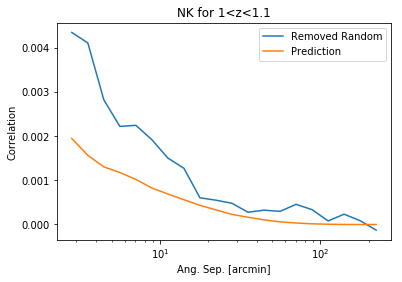

In [111]:
fixed = correlation-NK_random
plt.semilogx(R*60, fixed, label='Removed Random')
plt.semilogx(R*60, nk, label='Prediction')
plt.title('NK for 1<z<1.1')
plt.xlabel('Ang. Sep. [arcmin]')
plt.ylabel('Correlation')
plt.legend()
plt.show()